# 用于视觉的Transformer
:label:`sec_vision-transformer`

Transformer架构最初是为序列到序列学习提出的，重点在于机器翻译。随后，Transformer成为各种自然语言处理任务的首选模型 :cite:`Radford.Narasimhan.Salimans.ea.2018,Radford.Wu.Child.ea.2019,brown2020language,Devlin.Chang.Lee.ea.2018,raffel2020exploring`。然而，在计算机视觉领域，主导架构仍然是CNN（:numref:`chap_modern_cnn`）。自然而然地，研究人员开始思考是否可以通过将Transformer模型适应于图像数据来做得更好。这个问题在计算机视觉社区引发了极大的兴趣。最近，:citet:`ramachandran2019stand` 提出了一种用自注意力替代卷积的方案。然而，其在注意力中使用的特殊模式使得模型难以在硬件加速器上进行扩展。然后，:citet:`cordonnier2020relationship` 从理论上证明了自注意力可以学习到类似于卷积的行为。实验上，从图像中提取 $2 \times 2$ 的块作为输入，但小的块大小使得该模型仅适用于低分辨率的图像数据。

没有对块大小的具体限制，*视觉Transformer* (ViTs) 从图像中提取块，并将其输入到Transformer编码器以获得全局表示，最终该表示将被转换用于分类 :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。值得注意的是，与CNN相比，Transformer表现出更好的可扩展性：在更大规模的数据集上训练更大的模型时，视觉Transformer的表现显著优于ResNets。类似于自然语言处理中的网络架构设计格局，Transformer也成为计算机视觉领域的游戏规则改变者。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

:numref:`fig_vit` 描述了视觉Transformer的模型架构。该架构包括一个将图像分割成块的茎（stem），一个基于多层Transformer编码器的身体，以及一个将全局表示转换为输出标签的头部。

![The vision Transformer architecture. In this example, an image is split into nine patches. A special “&lt;cls&gt;” token and the nine flattened image patches are transformed via patch embedding and $\mathit{n}$ Transformer encoder blocks into ten representations, respectively. The “&lt;cls&gt;” representation is further transformed into the output label.](../img/vit.svg)
:label:`fig_vit`

考虑一个高度为$h$、宽度为$w$、通道数为$c$的输入图像。指定块的高度和宽度均为$p$，则图像被分割成$m = hw/p^2$个块序列，其中每个块被展平为长度为$cp^2$的向量。这样，图像块可以像文本序列中的标记一样被Transformer编码器处理。一个特殊的“&lt;cls&gt;”（类别）标记和$m$个展平的图像块被线性投影成一个由$m+1$个向量组成的序列，并加上可学习的位置嵌入。多层Transformer编码器将$m+1$个输入向量转换为相同数量的相同长度的输出向量表示。它的工作方式与:numref:`fig_transformer`中的原始Transformer编码器完全相同，只是归一化的位置不同。由于“&lt;cls&gt;”标记通过自注意力机制关注所有图像块（见:numref:`fig_cnn-rnn-self-attention`），其在Transformer编码器输出中的表示将进一步被转换为输出标签。

## 块嵌入

要实现视觉Transformer，让我们从:numref:`fig_vit`中的块嵌入开始。将图像分割成块并将这些展平的块线性投影可以简化为单一的卷积操作，其中内核大小和步幅大小都设置为块大小。

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

在下面的例子中，以高度和宽度为 `img_size` 的图像作为输入，
patch 嵌入输出 `(img_size//patch_size)**2` 个 patch，
这些 patch 被线性投影为长度为 `num_hiddens` 的向量。

In [3]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X),
                (batch_size, (img_size//patch_size)**2, num_hiddens))

## Vision Transformer 编码器
:label:`subsec_vit-encoder`

视觉Transformer编码器中的MLP与原始Transformer编码器的位置前馈网络（见 :numref:`subsec_positionwise-ffn`）略有不同。首先，这里激活函数使用的是高斯误差线性单元（GELU），可以认为是ReLU的一个更平滑的版本 :cite:`Hendrycks.Gimpel.2016`。其次，为了正则化，在MLP中每个全连接层的输出上应用了dropout。

In [4]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

视觉Transformer编码器块的实现遵循:numref:`fig_vit`中的预归一化设计，其中归一化在多头注意力或MLP之前立即应用。与后归一化（:numref:`fig_transformer`中的“加法和归一化”）不同，后归一化将归一化放置在残差连接之后，预归一化使得Transformer的训练更有效或更高效 :cite:`baevski2018adaptive,wang2019learning,xiong2020layer`。

In [5]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

正如在:numref:`subsec_transformer-encoder`中所述，没有任何视觉Transformer编码器块会改变其输入形状。

In [6]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)

## 将其整合

视觉Transformer的前向传递如下：
首先，输入图像被送入一个`PatchEmbedding`实例，
其输出与“&lt;cls&gt;”标记嵌入连接。
它们在dropout之前与可学习的位置嵌入相加。
然后，输出被送入堆叠了`num_blks`个`ViTBlock`类实例的Transformer编码器中。
最后，“&lt;cls&gt;”标记的表示由网络头部进行投影。

In [7]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

## 训练

在Fashion-MNIST数据集上训练视觉Transformer就像在:numref:`chap_modern_cnn`中训练CNN一样。

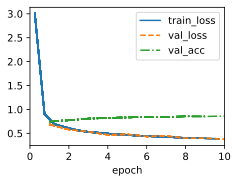

In [8]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

## 摘要与讨论

你可能已经注意到，对于像Fashion-MNIST这样的小数据集，
我们实现的视觉Transformer
并没有在:numref:`sec_resnet`中超越ResNet。
即使在ImageNet数据集（120万张图像）上也可以观察到类似的现象。
这是因为Transformers*缺乏*卷积中的那些有用原则，
例如平移不变性和局部性（:numref:`sec_why-conv`）。
然而，当在更大的数据集上训练更大模型时（例如3亿张图像），
视觉Transformers在图像分类方面大幅超越了ResNets，展示了
Transformers在可扩展性方面的内在优势 :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。
视觉Transformers的引入
改变了用于建模图像数据的网络设计格局。
它们很快被证明在使用DeiT的数据高效训练策略下对ImageNet数据集有效 :cite:`touvron2021training`。
然而，自注意力机制的二次复杂度
(:numref:`sec_self-attention-and-positional-encoding`)
使得Transformer架构
不太适合处理更高分辨率的图像。
为了构建计算机视觉中的通用骨干网络，
Swin Transformers解决了关于图像大小的二次计算复杂度问题
(:numref:`subsec_cnn-rnn-self-attention`)，
并重新引入了类似于卷积的先验知识，
将Transformers的应用范围扩展到了图像分类之外的一系列计算机视觉任务中，并取得了最先进结果 :cite:`liu2021swin`。

## 练习

1. `img_size`的值如何影响训练时间？
1. 不是将“&lt;cls&gt;”标记表示投影到输出，而是如何将平均patch表示进行投影？实施这一改变，看看它如何影响准确性。
1. 你能调整超参数以提高视觉Transformer的准确性吗？

[讨论](https://discuss.d2l.ai/t/8943)